In [5]:
import pandas as pd
import numpy as np
import pandas_ta as pta
import matplotlib.pyplot as plt
import os
from time import time


import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint


from sklearn.cluster import AgglomerativeClustering

%matplotlib inline

print("모든 라이브러리를 성공적으로 임포트했습니다.")

2025-08-26 01:19:35.200677: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


모든 라이브러리를 성공적으로 임포트했습니다.


In [6]:
def load_data(filepath='/Users/youngjaekim/fundamentals.csv'):

    df = pd.read_csv(filepath, header=[0, 1], index_col=0)
    
    
    df.index = pd.to_datetime(df.index, format='%d-%m-%Y')
    df.index.name = 'Dates'
    
    
    df.columns.names = ['Ticker', 'Feature']
    
    return df

print("데이터 로딩 함수가 준비되었습니다.")

데이터 로딩 함수가 준비되었습니다.


In [7]:
data = load_data('/Users/youngjaekim/fundamentals.csv')


data = data.iloc[-680:-1].copy()


for ticker in data.columns.levels[0]:
    for feature in data.columns.levels[1]:
        col_tuple = (ticker, feature)
        if col_tuple in data.columns:
            if 'VOLUME' in feature.upper():
                data[col_tuple] = pd.to_numeric(data[col_tuple], errors='coerce').astype(pd.Int64Dtype())
            else:
                data[col_tuple] = pd.to_numeric(data[col_tuple], errors='coerce').astype(float)

print("데이터 로딩 및 타입 변환 완료!")
data.head()

데이터 로딩 및 타입 변환 완료!


Ticker        SPX Index                                                     \
Feature         PX_OPEN      PX_HIGH       PX_LOW      PX_LAST   PX_VOLUME   
Dates                                                                        
2023-01-13  3960.600098  4003.949951  3947.669922  3999.090088  3939700000   
2023-01-16          NaN          NaN          NaN          NaN        <NA>   
2023-01-17  3999.280029  4015.389893  3984.570068  3990.969971  4235560000   
2023-01-18  4002.250000  4014.159912  3926.590088  3928.860107  4298710000   
2023-01-19  3911.840088  3922.939941  3885.540039  3898.850098  3991500000   

Ticker                                                                      \
Feature    PX_TO_BOOK_RATIO  PE_RATIO DIVIDEND_YIELD MARKET_CAP     EBITDA   
Dates                                                                        
2023-01-13        69.752600  7.686065     102.856062  44.425227  41.662965   
2023-01-16        71.841254  7.591438      88.941628  43.979476  38.912932   
2023-01-17        72.819142  7.865362      93.714961  43.215063  36.104349   
2023-01-18        75.710731  7.619952      94.312460  47.824735  35.410077   
2023-01-19        75.850893  7.823756     102.836715  43.040862  36.792623   

Ticker      ...    TWSE Index                                             \
Feature     ... CURRENT_RATIO QUICK_RATIO INTEREST_COVERAGE SALES_GROWTH   
Dates       ...                                                            
2023-01-13  ...     10.743941   30.734370          5.095635    56.444660   
2023-01-16  ...     10.196516   35.098865          5.306596    58.392120   
2023-01-17  ...      9.793899   31.482791          5.881072    54.808302   
2023-01-18  ...      9.544762   32.724067          4.946221    58.746332   
2023-01-19  ...      9.668249   33.563641          5.943591    59.585356   

Ticker                                                                  \
Feature    EPS_GROWTH       BETA      ALPHA SHARPE_RATIO SORTINO_RATIO   
Dates                                                                    
2023-01-13  62.808286  42.889623  42.498472    15.758017     21.692059   
2023-01-16  60.918187  44.628309  38.910724    19.562545     21.105558   
2023-01-17  59.570959  45.745476  41.203013    19.137737     18.850843   
2023-01-18  66.780203  46.212986  42.372712    18.944040     20.268045   
2023-01-19  61.145674  45.400121  36.859900    19.241337     20.501540   

Ticker                 
Feature       RSI_14D  
Dates                  
2023-01-13  18.299982  
2023-01-16  16.903780  
2023-01-17  18.145993  
2023-01-18  18.645984  
2023-01-19  19.457527  

[5 rows x 230 columns]

In [8]:
indices = list(data.columns.get_level_values(0).unique())
index_dict = {}

print("기술적 지표 계산을 시작합니다...")
for index in indices:
    df = data[index].copy()
    
    rename_dict = {
        'PX_OPEN': 'open', 'PX_HIGH': 'high', 'PX_LOW': 'low',
        'PX_LAST': 'close', 'PX_VOLUME': 'volume'
    }
    df.rename(columns=rename_dict, inplace=True)

    df.dropna(subset=['open', 'high', 'low', 'close', 'volume'], inplace=True)
    if df.empty: continue

    df['volume'] = df['volume'].astype('int64')

    # pandas-ta 기술적 지표 계산
    df.ta.rsi(append=True)
    df.ta.mfi(append=True)
    df.ta.adx(append=True)
    df.ta.obv(append=True)
    df.ta.atr(append=True)
    df.ta.ema(length=14, append=True)
    
    bbands = df.ta.bbands(length=20, append=False)
    if bbands is not None:
        df['Boll_upper'] = bbands[f'BBU_20_2.0']
        df['Boll_mid'] = bbands[f'BBM_20_2.0']
        df['Boll_lower'] = bbands[f'BBL_20_2.0']

    macd = df.ta.macd(fast=14, slow=30, append=False)
    if macd is not None:
        df['MACD'] = macd[f'MACD_14_30_9']
    
    # 로그 수익률 계산
    if 'close' in df.columns:
        for i in range(1, 49):
            df[f'LR_{i}'] = np.log(df['close']) - np.log(df['close'].shift(i))
    
    df.dropna(inplace=True, axis=0)
    
    # 0-1 정규화
    for col in df.columns:
        min_val, max_val = df[col].min(), df[col].max()
        if max_val - min_val > 0:
            df[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            df[col] = 0
            
    index_dict[index] = df

print("기술적 지표 계산 및 정규화 완료!")

기술적 지표 계산을 시작합니다...


/var/folders/8l/4_fpxyr51vdgqv070yhckk540000gn/T/ipykernel_15755/2278066121.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.69294344e+13 1.58439830e+13 1.58212916e+13 1.54101599e+13
 1.59091031e+13 1.89889924e+13 1.99220909e+13 2.34668539e+13
 1.80462262e+13 1.42184992e+13 1.62287877e+13 1.68469627e+13
 1.58246862e+13 1.53143419e+13 1.68385987e+13 1.64602363e+13
 1.62322231e+13 2.21539482e+13 2.23822715e+13 2.10767862e+13
 1.96533085e+13 1.68662118e+13 1.66610450e+13 1.59079025e+13
 1.85171530e+13 1.74342034e+13 1.42747180e+13 1.40268765e+13
 1.50736603e+13 1.48609659e+13 1.47962413e+13 1.49577726e+13
 1.46943973e+13 1.35995026e+13 1.54383644e+13 1.69871530e+13
 1.38599775e+13 1.72585958e+13 1.50572467e+13 1.67572066e+13
 1.47091496e+13 1.67447602e+13 1.66567340e+13 1.69558922e+13
 1.72087106e+13 1.55733264e+13 1.78003361e+13 1.84825431e+13
 1.90254469e+13 1.63207409e+13 1.63950422e+13 1.62986286

기술적 지표 계산 및 정규화 완료!


In [9]:
# 빈 데이터프레임 제거
index_keys = list(index_dict.keys())
for index in index_keys:
    if index_dict[index].shape[0] == 0:
        del index_dict[index]

indices = list(index_dict.keys())

# 모든 데이터프레임 길이를 통일
min_len = min(len(df) for df in index_dict.values())
print(f"모든 데이터의 길이를 가장 짧은 길이인 {min_len}으로 통일합니다.")
trimmed_index_dict = {index: df.tail(min_len) for index, df in index_dict.items()}

# 모델 입력을 위한 4차원 데이터(N, T, F, C) 생성
n_timesteps = min_len
n_features = trimmed_index_dict[indices[0]].shape[1]
n_indices = len(indices)

x = np.array([df.values for df in trimmed_index_dict.values()])
x = x.reshape(n_indices, n_timesteps, n_features, 1).astype('float32')

print(f"모델 입력 데이터(x) 형태: {x.shape}")

모든 데이터의 길이를 가장 짧은 길이인 580으로 통일합니다.
모델 입력 데이터(x) 형태: (10, 580, 83, 1)


In [10]:
args = {
    'n_clusters': 5,
    'batch_size': 16,
    'epochs': 50, 
    'save_dir': 'results'
}
if not os.path.exists(args['save_dir']):
    os.makedirs(args['save_dir'])

input_shape = x.shape[1:]
filters = [32, 64, 128, 10]
pad3 = 'valid'

# --- 인코더 (Functional API) ---
encoder_input = Input(shape=input_shape, name='encoder_input')
x_enc = Conv2D(filters[0], 5, padding='same', activation='relu', name='conv1')(encoder_input)
x_enc = Conv2D(filters[1], 5, padding='same', activation='relu', name='conv2')(x_enc)
conv3_output = Conv2D(filters[2], 3, padding=pad3, activation='relu', name='conv3')(x_enc)
flatten_output = Flatten(name='flatten')(conv3_output)
embedding = Dense(units=filters[3], name='embedding')(flatten_output)
encoder = Model(encoder_input, embedding, name='encoder')

# --- 디코더 (Functional API) ---
decoder_input = Input(shape=(filters[3],), name='decoder_input')
x_dec = Dense(units=flatten_output.shape[1], activation='relu')(decoder_input)
x_dec = Reshape(conv3_output.shape[1:])(x_dec)
x_dec = Conv2DTranspose(filters[1], 3, padding=pad3, activation='relu', name='deconv3')(x_dec)
x_dec = Conv2DTranspose(filters[0], 5, padding='same', activation='relu', name='deconv2')(x_dec)
decoder_output = Conv2DTranspose(input_shape[2], 5, padding='same', name='deconv1')(x_dec)
decoder = Model(decoder_input, decoder_output, name='decoder')

# --- 오토인코더 모델 결합 ---
autoencoder = Model(encoder.input, decoder(encoder.output), name='autoencoder')

print("Functional API를 사용하여 모델을 성공적으로 구축했습니다.")
autoencoder.summary()

Functional API를 사용하여 모델을 성공적으로 구축했습니다.


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 580, 83, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 580, 83, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 580, 83, 64)    │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 578, 81, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5992704)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 10)             │    59,927,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 580, 83, 1)     │    66,045,569 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,098,571 (481.03 MB)

 Trainable params: 126,098,571 (481.03 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
autoencoder.compile(optimizer='adam', loss='mse')
csv_logger = CSVLogger(os.path.join(args['save_dir'], 'pretrain-log.csv'))
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(args['save_dir'], 'best_model.h5'), 
    monitor='loss', 
    save_best_only=True
)

print("\n모델 학습을 시작합니다...")
autoencoder.fit(x, x, 
                batch_size=args['batch_size'], 
                epochs=args['epochs'], 
                verbose=1, 
                callbacks=[csv_logger, model_checkpoint])
print('학습 완료!')


모델 학습을 시작합니다...
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - loss: 0.3183

1/1 ━━━━━━━━━━━━━━━━━━━━ 46s 46s/step - loss: 0.3183
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - loss: 0.3033

1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step - loss: 0.3033
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 0.2791

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - loss: 0.2791
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - loss: 0.1192

1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - loss: 0.1192
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 0.3440
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - loss: 0.2098
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - loss: 0.2653
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step - loss: 0.2526
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - loss: 0.1963
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 0.0657

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - loss: 0.0657
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 0.4084
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 0.0367

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - loss: 0.0367
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - loss: 0.1076
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 0.1706
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.1962
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.1983
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.1833
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.1513
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.1006
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 0.0431
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.0566
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.1068
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.0537
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0272

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 0.0272
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0401
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0540
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.0558
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0458
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0298
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0211

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 0.0211
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0305
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0404
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0296
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.0190

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 0.0190
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.0214
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.0277
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0293
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.0247
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.0184

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 0.0184
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0170

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 0.0170
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.0218
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0233
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0185
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0157

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 0.0157
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 0.0176
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.0198
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.0192
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0165
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 0.0150

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 0.0150
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0164
학습 완료!


In [28]:
features_ae = encoder.predict(x)

agg_clustering = AgglomerativeClustering(n_clusters=args['n_clusters'])
pred_ae = agg_clustering.fit_predict(features_ae)

cluster_df_ae = pd.DataFrame({'Index': indices, 'Cluster': pred_ae})
print("--- 딥러닝(Autoencoder) 클러스터링 그룹 ---")
for i in sorted(cluster_df_ae['Cluster'].unique()):
    cluster_indices = cluster_df_ae[cluster_df_ae['Cluster'] == i]['Index'].values
    print(f'--- Cluster {i} ---\n{list(cluster_indices)}\n')
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
--- 딥러닝(Autoencoder) 클러스터링 그룹 ---
--- Cluster 0 ---
['DAX Index', 'UKX Index', 'ASX Index']

--- Cluster 1 ---
['NDX Index', 'SXXP Index']

--- Cluster 2 ---
['SPX Index', 'INDU Index', 'SMI Index']

--- Cluster 3 ---
['TWSE Index']

--- Cluster 4 ---
['CAC Index']



In [30]:
feature_list = [df.values.flatten() for df in trimmed_index_dict.values()]
X_features = np.array(feature_list)

print("PCA 및 클러스터링을 위한 특징 행렬 준비 완료")
print(f"특징 행렬 형태: {X_features.shape}")

PCA 및 클러스터링을 위한 특징 행렬 준비 완료
특징 행렬 형태: (10, 48140)


In [31]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components=10, random_state=42)
features_pca = pca.fit_transform(X_features)
print("PCA를 통한 특징 추출(차원 축소) 완료")

kmeans = KMeans(n_clusters=args['n_clusters'], random_state=42, n_init='auto')
pred_pca = kmeans.fit_predict(features_pca)

cluster_df_pca = pd.DataFrame({'Index': indices, 'Cluster': pred_pca})
print("\n--- 고전방식(PCA + K-Means) 클러스터링 그룹 ---")
for i in sorted(cluster_df_pca['Cluster'].unique()):
    cluster_indices = cluster_df_pca[cluster_df_pca['Cluster'] == i]['Index'].values
    print(f'--- Cluster {i} ---\n{list(cluster_indices)}\n')

PCA를 통한 특징 추출(차원 축소) 완료

--- 고전방식(PCA + K-Means) 클러스터링 그룹 ---
--- Cluster 0 ---
['DAX Index', 'UKX Index', 'CAC Index']

--- Cluster 1 ---
['TWSE Index']

--- Cluster 2 ---
['SPX Index', 'INDU Index', 'NDX Index']

--- Cluster 3 ---
['SXXP Index', 'SMI Index']

--- Cluster 4 ---
['ASX Index']



딥러닝(Autoencoder) 방식 실루엣 점수: 0.5243
고전(PCA) 방식 실루엣 점수:          0.0797

💡 결론: 딥러닝 방식이 더 명확


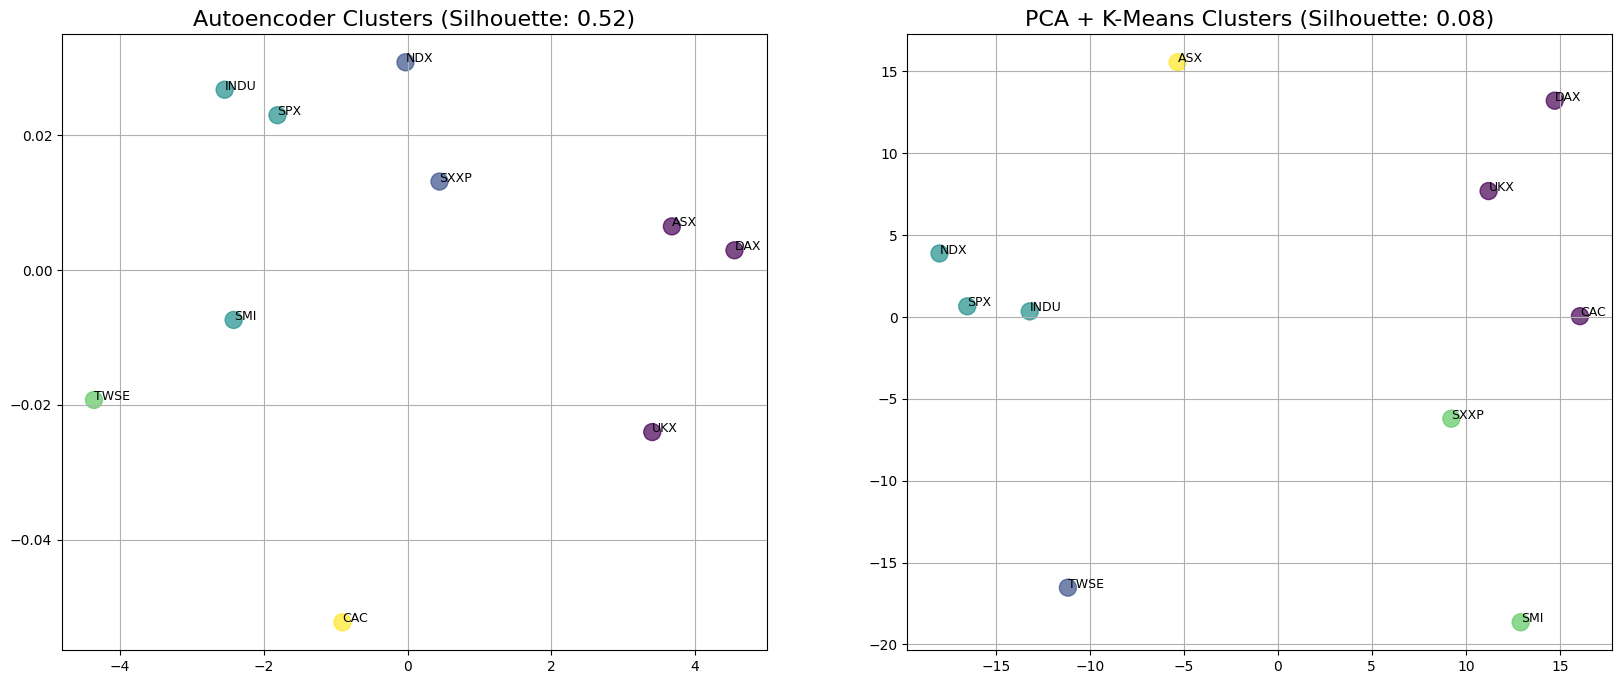

In [32]:
from sklearn.metrics import silhouette_score

silhouette_ae = silhouette_score(features_ae, pred_ae)
silhouette_pca = silhouette_score(features_pca, pred_pca)

print(f"딥러닝(Autoencoder) 방식 실루엣 점수: {silhouette_ae:.4f}")
print(f"고전(PCA) 방식 실루엣 점수:          {silhouette_pca:.4f}")

if silhouette_ae > silhouette_pca:
    print("\n💡 결론: 딥러닝 방식이 더 명확")
else:
    print("\n💡 결론: 고전 방식(PCA)이 더 명확")


# 시각화 비교
pca_2d_ae = PCA(n_components=2, random_state=42)
features_ae_2d = pca_2d_ae.fit_transform(features_ae)

pca_2d_pca = PCA(n_components=2, random_state=42)
features_pca_2d = pca_2d_pca.fit_transform(features_pca)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 딥러닝(오토인코더) 결과 시각화
axes[0].set_title(f'Autoencoder Clusters (Silhouette: {silhouette_ae:.2f})', fontsize=16)
scatter1 = axes[0].scatter(features_ae_2d[:, 0], features_ae_2d[:, 1], c=pred_ae, cmap='viridis', s=150, alpha=0.7)
for i, txt in enumerate(indices):
    axes[0].annotate(txt.replace(' Index',''), (features_ae_2d[i, 0], features_ae_2d[i, 1]), fontsize=9)
axes[0].grid(True)

# 고전(PCA) 결과 시각화
axes[1].set_title(f'PCA + K-Means Clusters (Silhouette: {silhouette_pca:.2f})', fontsize=16)
scatter2 = axes[1].scatter(features_pca_2d[:, 0], features_pca_2d[:, 1], c=pred_pca, cmap='viridis', s=150, alpha=0.7)
for i, txt in enumerate(indices):
    axes[1].annotate(txt.replace(' Index',''), (features_pca_2d[i, 0], features_pca_2d[i, 1]), fontsize=9)
axes[1].grid(True)

plt.show()